In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import niskine
import mplniw.plot as pl

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/'

In [221]:
mld_all = xr.open_dataset(conf.data.input.argo_mld).set_coords({'month':'iMONTH','longrid':'iLON','latgrid':'iLAT'})
wind_work = xr.open_dataset(root_dir+'data/wind_work/ni_wind_work_niskine_m1.nc')
gridded = xr.open_dataset(root_dir+'data/gridded/M1_gridded_simple_merge_gaps_filled.nc')
#wind_work = xr.open_mfdataset(conf.data.wind_work,parallel=True)

In [222]:
mld_all

<xarray.Dataset>
Dimensions:        (iLAT: 180, iLON: 360, iMONTH: 12)
Coordinates:
    month          (iMONTH) float64 ...
    longrid        (iLAT, iLON) float64 ...
    latgrid        (iLAT, iLON) float64 ...
Dimensions without coordinates: iLAT, iLON, iMONTH
Data variables: (12/17)
    lat            (iLAT) float64 ...
    lon            (iLON) float64 ...
    mld_da_mean    (iLAT, iLON, iMONTH) float64 ...
    mld_dt_mean    (iLAT, iLON, iMONTH) float64 ...
    mld_da_median  (iLAT, iLON, iMONTH) float64 ...
    mld_dt_median  (iLAT, iLON, iMONTH) float64 ...
    ...             ...
    mlpd_dt        (iLAT, iLON, iMONTH) float64 ...
    mlt_da         (iLAT, iLON, iMONTH) float64 ...
    mlt_dt         (iLAT, iLON, iMONTH) float64 ...
    mls_da         (iLAT, iLON, iMONTH) float64 ...
    mls_dt         (iLAT, iLON, iMONTH) float64 ...
    num            (iLAT, iLON, iMONTH) float64 ...
Attributes:
    description:  This file was created using \n matlab R2011b with NETCDF Li...
    date:         [730848.53015047 730848.88790506 730849.28543982 ... 738591...

In [14]:
def ni_bandpass_adcp(adcp, bandwidth=1.06):
    tlow, thigh = niskine.calcs.determine_ni_band(bandwidth=1.06)
    outu = adcp.u.copy()
    outu = outu.interpolate_na(dim="time", max_gap=np.timedelta64(8, "h"))
    outv = adcp.v.copy()
    outv = outv.interpolate_na(dim="time", max_gap=np.timedelta64(8, "h"))
    i = 0
    for g, aai in outu.groupby("z"):
        outu[i, :] = niskine.calcs.bandpass_time_series(aai.data, tlow, thigh, fs=6)
        i += 1
    i = 0
    for g, aai in outv.groupby("z"):
        outv[i, :] = niskine.calcs.bandpass_time_series(aai.data, tlow, thigh, fs=6)
        i += 1
    adcp["bpu"] = outu
    adcp["bpv"] = outv
    return adcp
    
def calc_ni_eke(adcp):
    rho = 1025
    # load WKB normalization matrix
    wkb = niskine.clim.get_wkb_factors(adcp)
    # calculate NI EKE
    adcp["ni_eke"] = 0.5 * rho * ((wkb * adcp.bpu) ** 2 + (wkb * adcp.bpv) ** 2)
    return adcp,wkb

In [7]:
ds_filtered = ni_bandpass_adcp(gridded)

In [15]:
ds_filt,wkb = calc_ni_eke(ds_filtered)
ds_filt


<xarray.Dataset>
Dimensions:       (z: 106, time: 72966, adcp: 3)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-05T08...
  * z             (z) int64 0 16 32 48 64 80 ... 1600 1616 1632 1648 1664 1680
  * adcp          (adcp) int64 3109 9408 13481
Data variables:
    u             (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    v             (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    xducer_depth  (adcp, time) float64 ...
    temperature   (adcp, time) float64 ...
    n2            (z, time) float64 2.251e-06 2.251e-06 ... 1.244e-06 1.244e-06
    N             (z, time) float64 0.0015 0.0015 0.0015 ... 0.001115 0.001115
    bpu           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    bpv           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ni_eke        (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ke            (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    eke           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    project:       NISKINe
    mooring:       M1
    lon:           -21.198829621395166
    lat:           59.101445324829214
    bottom_depth:  2881.0

In [18]:
ds_filt['ke'] = 0.5*(ds_filt.u**2+ds_filt.v**2)
ds_filt['eke'] = 0.5*((ds_filt.u-ds_filt.u.mean())**2+(ds_filt.v-ds_filt.v.mean())**2)
ds_filt['bpu_wkb'] = ds_filt['bpu']*wkb
ds_filt['bpv_wkb'] = ds_filt['bpv']*wkb
ds_filt

<xarray.Dataset>
Dimensions:       (z: 106, time: 72966, adcp: 3)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-05T08...
  * z             (z) int64 0 16 32 48 64 80 ... 1600 1616 1632 1648 1664 1680
  * adcp          (adcp) int64 3109 9408 13481
Data variables: (12/13)
    u             (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    v             (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    xducer_depth  (adcp, time) float64 ...
    temperature   (adcp, time) float64 ...
    n2            (z, time) float64 2.251e-06 2.251e-06 ... 1.244e-06 1.244e-06
    N             (z, time) float64 0.0015 0.0015 0.0015 ... 0.001115 0.001115
    ...            ...
    bpv           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ni_eke        (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ke            (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    eke           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    bpu_wkb       (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    bpv_wkb       (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    project:       NISKINe
    mooring:       M1
    lon:           -21.198829621395166
    lat:           59.101445324829214
    bottom_depth:  2881.0

In [19]:
wkb

<xarray.DataArray 'wkb normalization factor' (z: 106, time: 72966)>
array([[1.2101754 , 1.2101754 , 1.2101754 , ..., 1.2101754 , 1.2101754 ,
        1.2101754 ],
       [0.78383336, 0.78373058, 0.78362787, ..., 1.19020112, 1.19031764,
        1.19043422],
       [0.87541284, 0.87502972, 0.87464744, ..., 0.75934538, 0.75944928,
        0.75955324],
       ...,
       [1.40776741, 1.40776945, 1.40777149, ..., 1.41018109, 1.41018348,
        1.41018586],
       [1.40727428, 1.40727586, 1.40727744, ..., 1.40689807, 1.4069003 ,
        1.40690253],
       [1.40678202, 1.40678314, 1.40678426, ..., 1.40365291, 1.40365498,
        1.40365706]])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-05T08:50:00
  * z        (z) int64 0 16 32 48 64 80 96 ... 1600 1616 1632 1648 1664 1680

(<Figure size 1800x500 with 6 Axes>, <Axes: xlabel='time', ylabel='depth [m]'>)

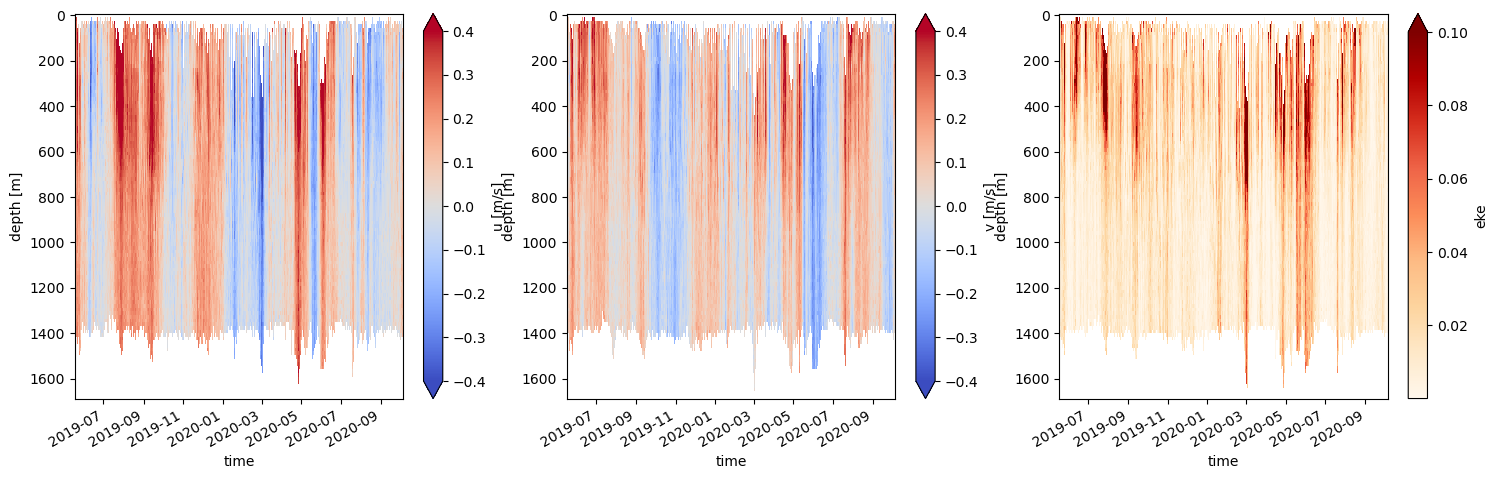

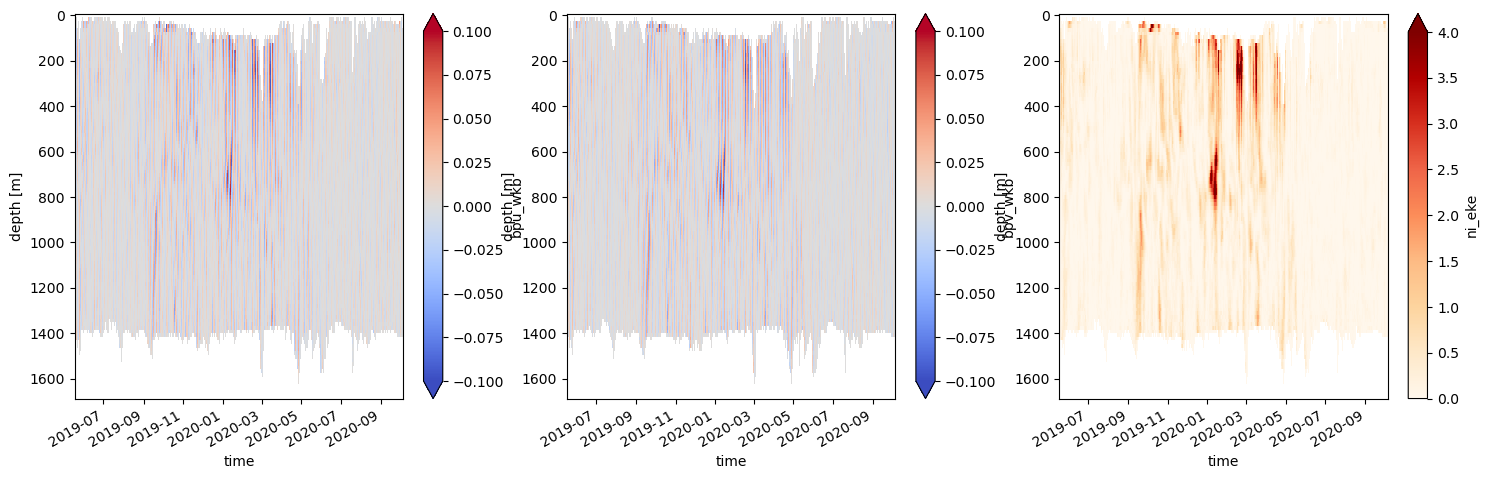

In [21]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
pl.plot_uv(ds_filt,'u',fig,ax)
ax = fig.add_subplot(132)
pl.plot_uv(ds_filt,'v',fig,ax)
ax = fig.add_subplot(133)
pl.plot_uv(ds_filt,'eke',fig,ax,vmax=0.1,cmap='OrRd')

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
pl.plot_uv(ds_filt,'bpu_wkb',fig,ax,vmax=0.1)
ax = fig.add_subplot(132)
pl.plot_uv(ds_filt,'bpv_wkb',fig,ax,vmax=0.1)
ax = fig.add_subplot(133)
pl.plot_uv(ds_filt,'ni_eke',fig,ax,vmax=4,cmap='OrRd')

In [25]:
# Wind event identification
def find_event(wind, threshold, duration):
    dt = wind_work.time.diff('time').mean().values
    events = wind.time.where(wind>threshold,drop=True)
    return events

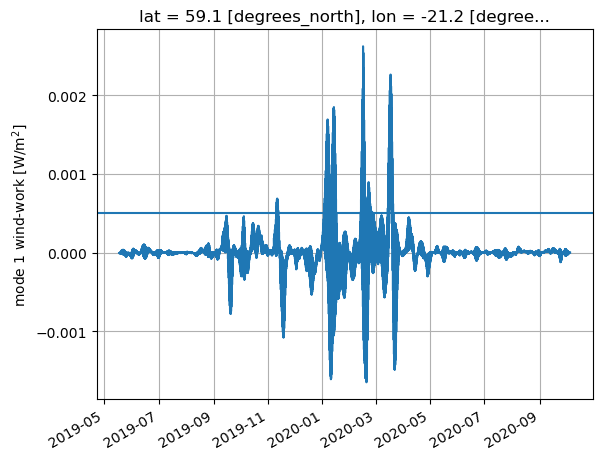

In [45]:
#Defining a threshold:
fig,ax = plt.subplots()
wind_work['NISKINE M1 mode1 wind-work'].plot(ax=ax)
ax.grid();ax.axhline(0.0005)

In [46]:
dt = wind_work.time.diff('time').mean()
event = find_event(wind_work,0.0005)

In [120]:
dt*1e-9

<xarray.DataArray 'time' ()>
array(3600, dtype='timedelta64[ns]')
Coordinates:
    lat      float64 ...
    lon      float64 ...
    z        float64 ...
    mode     int64 ...

In [165]:
time_ = event.time.where(event.time.diff('time')>6*dt,drop=True).time
duration = (time_.diff('time')*1e-9)/3600
#ds_events = ds_filt.sel(time=time_.values)

In [370]:
# a la main:

ti = ['2019-11-10T02:00:00.000000000','2020-01-03T01:00:00.000000000',
      '2020-02-13T02:00:00.000000000','2020-03-08T12:00:00.000000000']
tf = ['2019-11-19T09:00:00.000000000','2020-01-16T14:00:00.000000000',
      '2020-02-26T19:00:00.000000000','2020-03-23T04:00:00.000000000']
months=[11,1,2,3]

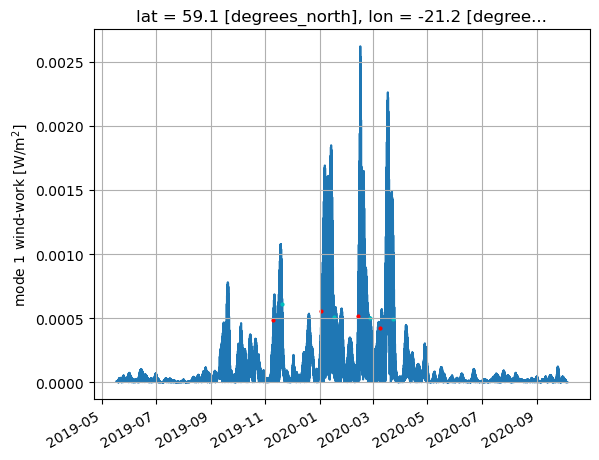

In [371]:
fig,ax = plt.subplots()
np.abs(wind_work['NISKINE M1 mode1 wind-work']).plot(ax=ax,zorder=-1)
ax.grid();#ax.axhline(0.0005)
ax.scatter(ti,np.abs(wind_work['NISKINE M1 mode1 wind-work'].sel(time=ti)),s=4,c='r',zorder=1)
ax.scatter(tf,np.abs(wind_work['NISKINE M1 mode1 wind-work'].sel(time=tf)),s=4,c='c',zorder=1)

In [372]:
#mld = mld_all.sel(iLON=int(lon),iLAT=int(lat))
mld_da = xr.DataArray(data=mld_all.mld_da_mean.data, coords=dict(lon=mld_all.lon.data, lat=mld_all.lat.data, month=mld_all.month.data), dims=('lat', 'lon', 'month'), name='da')
mld_dt = xr.DataArray(data=mld_all.mld_dt_mean.data, coords=dict(lon=mld_all.lon.data, lat=mld_all.lat.data, month=mld_all.month.data), dims=('lat', 'lon', 'month'), name='dt')


In [373]:
mld = mld_da.sel(lon=lon,lat=lat,method='nearest')

In [388]:
def plot_event2D(ds,v,ti,tf,months,**kwargs):
    fig,axs = plt.subplots(1,len(ti),figsize=(5*len(ti),6))
    for i in range(len(ti)):
        ds_filt.sel(time=slice(ti[i],tf[i]))[v].plot(ax=axs[i],y='z',yincrease=False,**kwargs)
        axs[i].axhline(mld.sel(month=months[i]),c='c',lw=2)
        axs[i].set_title('Month %s'%months[i])
    return fig,ax

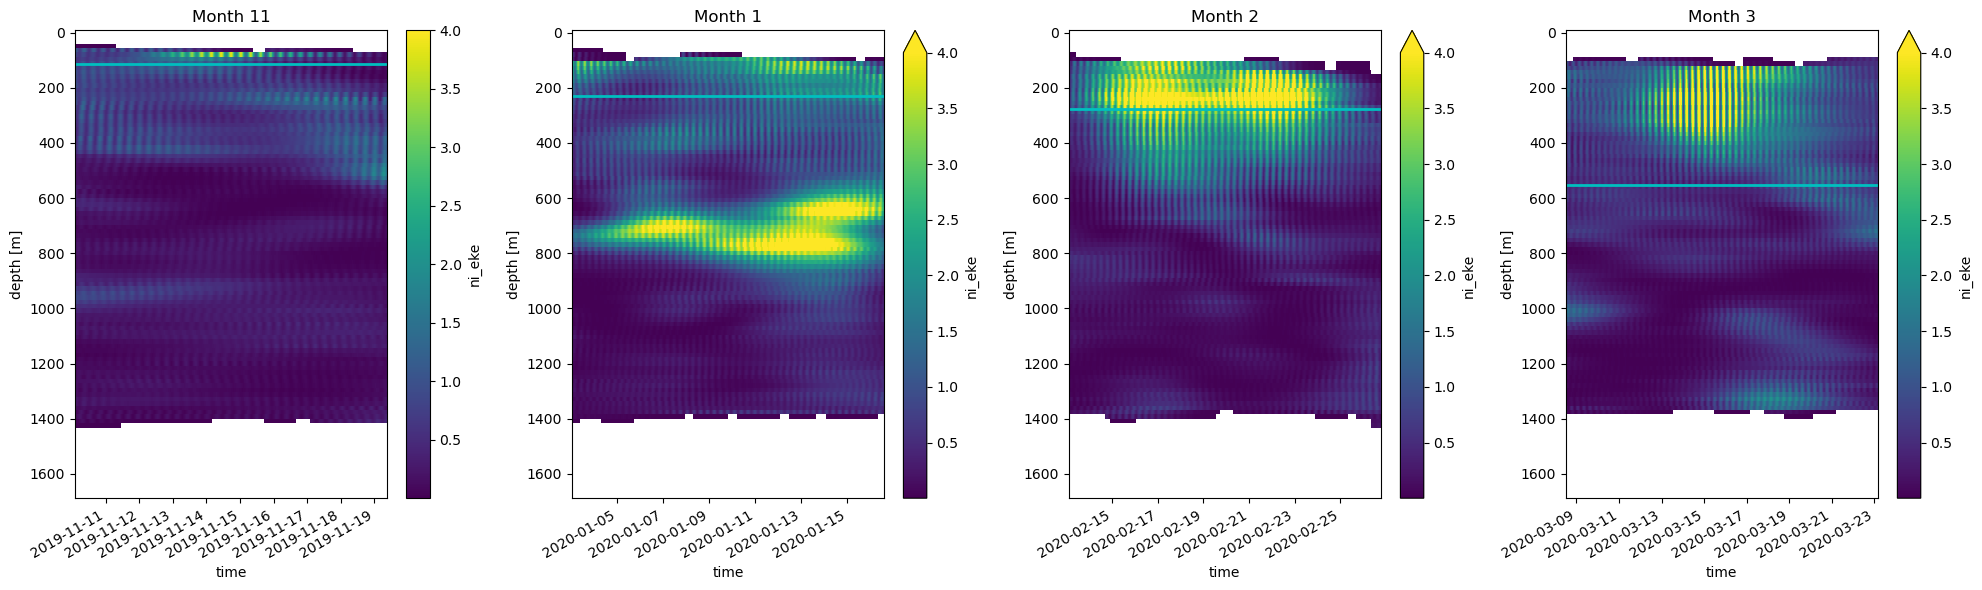

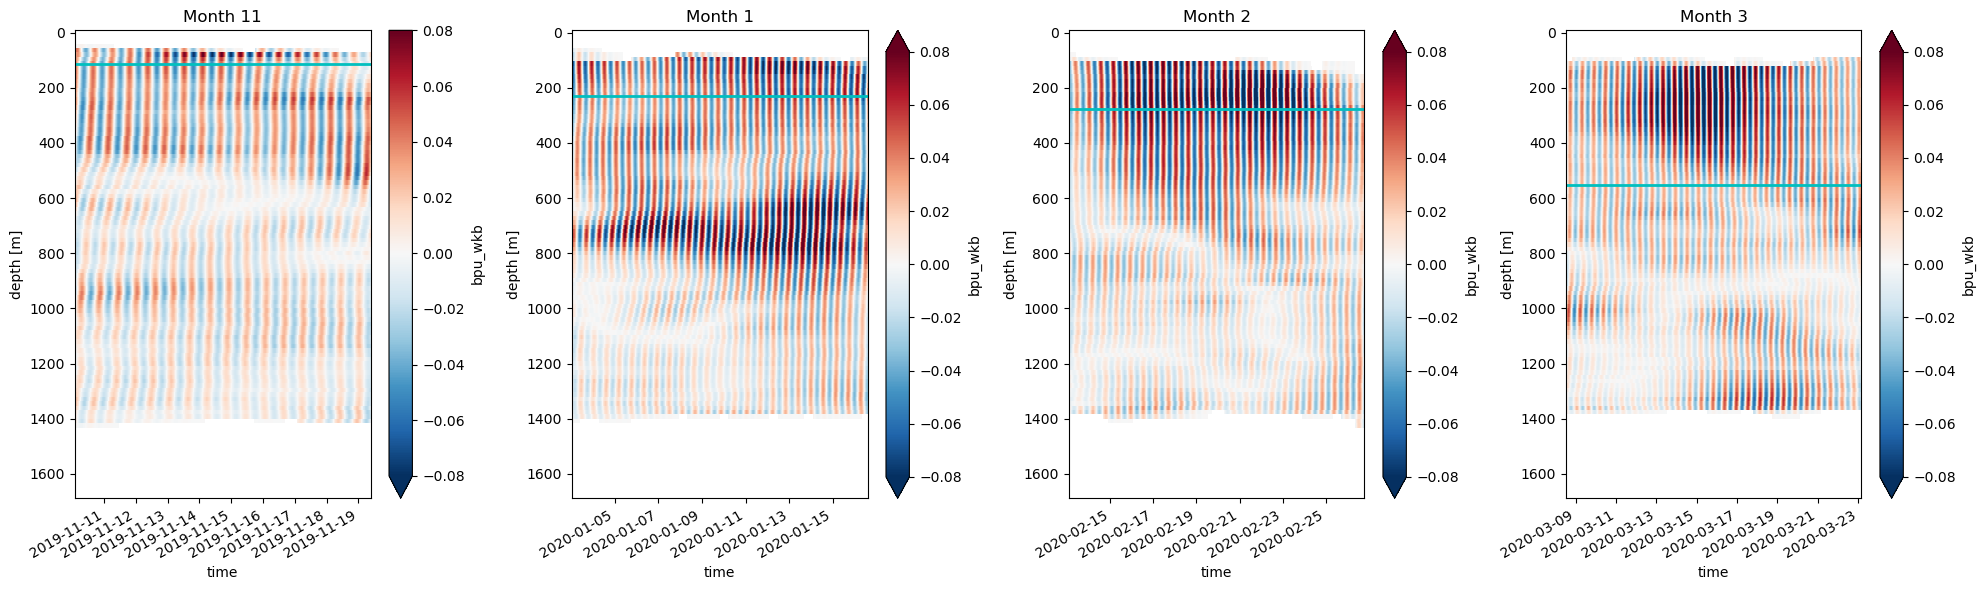

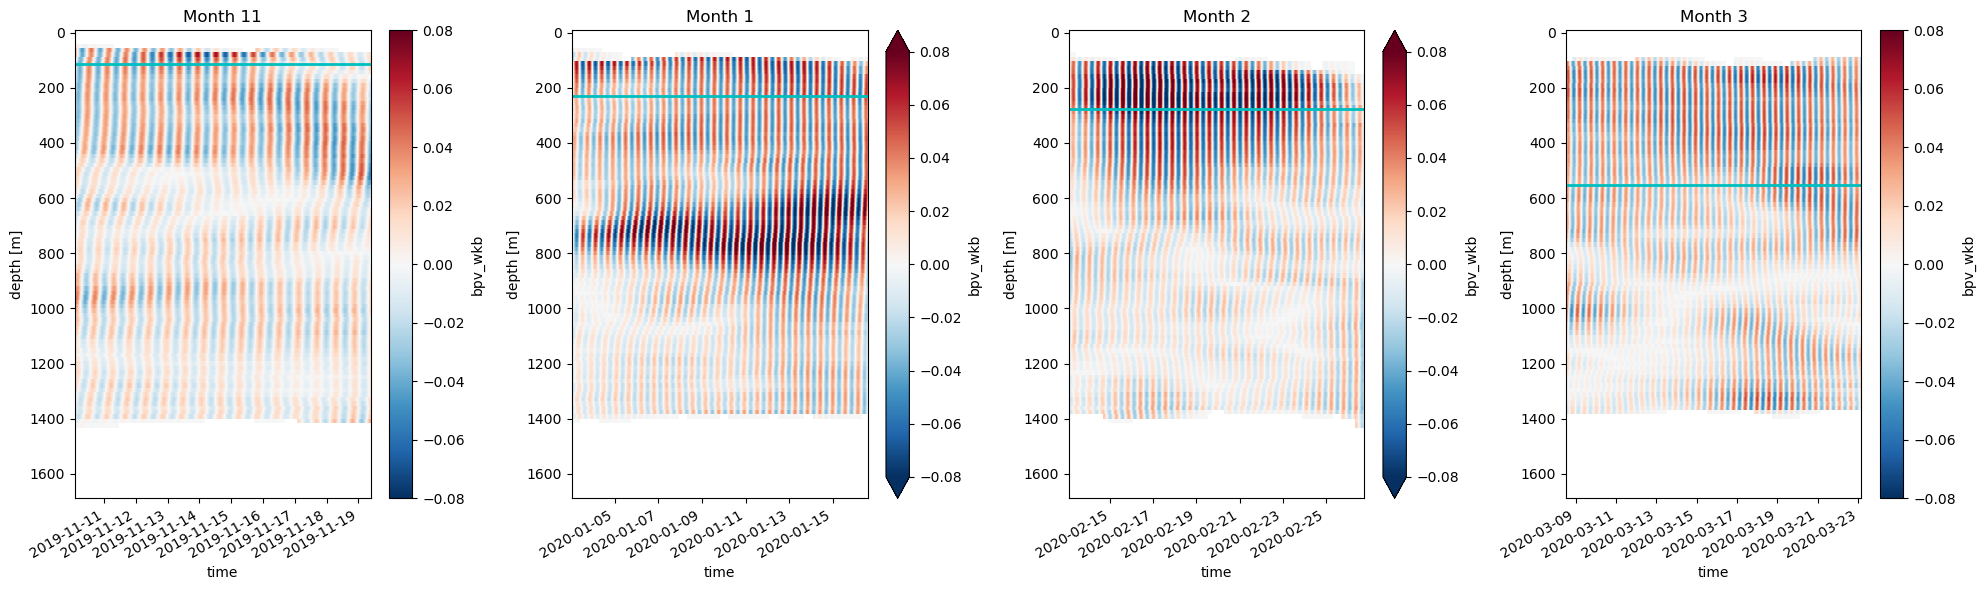

In [393]:
#NI EKE
fig,ax = plot_event2D(ds_filt,'ni_eke',ti,tf,months,**{'vmax':4})
fig.tight_layout()
#NI u
fig,ax = plot_event2D(ds_filt,'bpu_wkb',ti,tf,months,**{'vmax':0.08})
fig.tight_layout()
#NI v
fig,ax = plot_event2D(ds_filt,'bpv_wkb',ti,tf,months,**{'vmax':0.08})
fig.tight_layout()

In [394]:
import matplotlib.pylab as plb
n = len(ti)
colors = plb.cm.Blues_r(np.linspace(0,0.7,n))

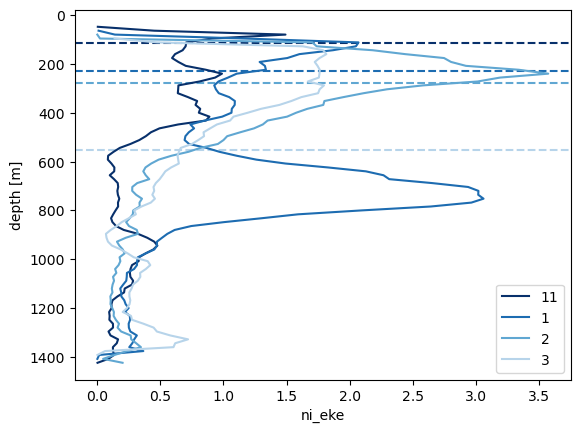

In [395]:
fig,ax = plt.subplots()
for i in range(len(ti)):
    ds_filt.sel(time=slice(ti[i],tf[i])).ni_eke.mean('time').plot(ax=ax,y='z',yincrease=False,label=str(months[i]),
                                                                  c=colors[i],zorder=1)
    ax.axhline(mld.sel(month=months[i]),c=colors[i],zorder=-1,ls='--')
ax.legend();#ax.grid();

In [156]:
extended = time_.where(time_.diff('time')>7*dt,drop=True)

In [157]:
ti = xr.concat([time_[0],extended[1::2]],dim='time')
tf = xr.concat([extended[0],extended[2::2]],dim='time')

In [159]:
ti

<xarray.DataArray 'time' (time: 7)>
array(['2019-11-10T08:00:00.000000000', '2020-01-03T01:00:00.000000000',
       '2020-01-09T19:00:00.000000000', '2020-01-16T14:00:00.000000000',
       '2020-02-17T02:00:00.000000000', '2020-02-26T19:00:00.000000000',
       '2020-03-19T11:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-11-10T08:00:00 ... 2020-03-19T11:00:00
    lat      float64 59.1
    lon      float64 -21.2
    z        float64 0.0
    mode     int64 1
Attributes:
    long_name:

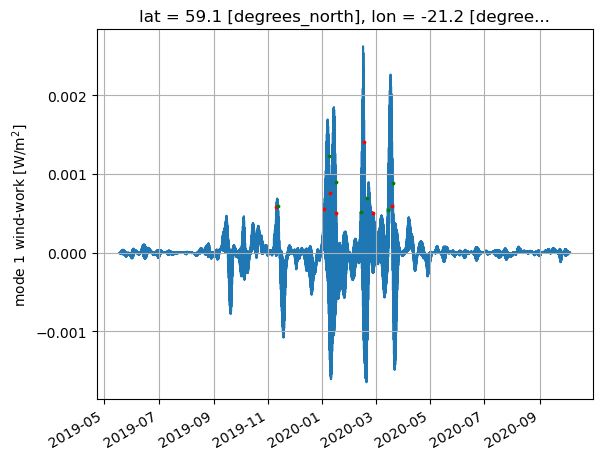

In [108]:
ds_events.sel(time=slice(time_[0],time_[1]))

<xarray.Dataset>
Dimensions:       (z: 106, time: 2, adcp: 3)
Coordinates:
  * time          (time) datetime64[ns] 2019-11-10T08:00:00 2019-11-10T15:00:00
  * z             (z) int64 0 16 32 48 64 80 ... 1600 1616 1632 1648 1664 1680
  * adcp          (adcp) int64 3109 9408 13481
Data variables: (12/13)
    u             (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    v             (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    xducer_depth  (adcp, time) float64 ...
    temperature   (adcp, time) float64 ...
    n2            (z, time) float64 2.251e-06 2.251e-06 ... 1.169e-06 1.168e-06
    N             (z, time) float64 0.0015 0.0015 ... 0.001081 0.001081
    ...            ...
    bpv           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ni_eke        (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ke            (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    eke           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    bpu_wkb       (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    bpv_wkb       (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    project:       NISKINe
    mooring:       M1
    lon:           -21.198829621395166
    lat:           59.101445324829214
    bottom_depth:  2881.0

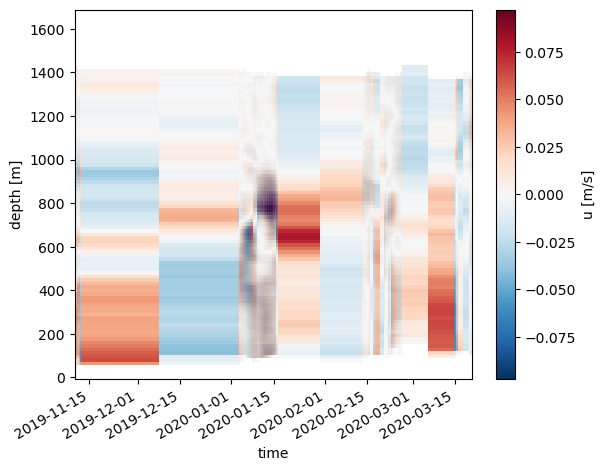

In [51]:
ds_filt.sel(time=time_).bpu.plot()

### Comment Sam Kelly:
A detailed figure showing some near-inertial velocities and mixed layer depth after a wind wind event would be useful for visualizing the scale of the response and vertical propagation.  Maybe one wind event with a medium (but still observable) mixed layer and one with a super deep mixed layer?